# Confidence Intervals

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

import warnings

warnings.simplefilter("ignore")

import os
import sys
import numpy as np

from itertools import product
from cycler import cycler
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-colorblind")
PLT_COLOR = plt.rcParams["axes.prop_cycle"].by_key()["color"]
PLT_LINES = ["-", "--", ":", "-."]
PLT_CYCLER = cycler(color=PLT_COLOR * 2) + cycler(linestyle=PLT_LINES * 3)

import pandas as pd

pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)
pd.plotting.register_matplotlib_converters()


import logging

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

In [2]:
import scipy
from functools import partial
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

from xgboost.sklearn import XGBRegressor

In [3]:
np.random.seed(1)

# Plot Results

In [4]:
def plot_result_toax(ax, alpha, preds, X_train, y_train, X_test, y_test):

    assert len(preds) == 3, "Predicitons require 3 entries"
    y_lower, y_pred, y_upper = preds

    fill_color = PLT_COLOR[0]

    ax.fill(
        np.concatenate([X_test, X_test[::-1]]),
        np.concatenate([y_upper, y_lower[::-1]]),
        alpha=0.2,
        fc=fill_color,
        ec="none",
        label="{:.0%} prediction interval".format(alpha),
    )
    ax.plot(X_test, y_upper, "-", color=fill_color)
    ax.plot(X_test, y_lower, "-", color=fill_color)
    ax.plot(X_test, y_test, "-k", label="$f(x) = x\,\sin(x)$")
    ax.plot(X_train, y_train, ".", markersize=5, label="Observations")
    ax.plot(X_test, y_pred, "-r", label="Prediction")
    ax.legend(loc="upper left")
    return ax


def plot_result(alpha, preds, X_train, y_train, X_test, y_test):
    fig, ax = plt.subplots(1, 1, figsize=(15, 5), sharex=True)
    _ = plot_result_toax(ax, alpha, preds, X_train, y_train, X_test, y_test)
    return ax

# Parameters

In [5]:
ALPHA = 0.95
QUANTILES = [1 - ALPHA, 0.5, ALPHA]

# Generate Data

In [6]:
def generate_data(random_seed=1, xmin=-10, xmax=30, size=2000):
    """
    Generates data sample as seen in 'Prediction Intervals for Gradient Boosting Regression'
    https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html
    """
    np.random.seed(random_seed)
    f = lambda u: u * np.sin(u) + u * np.sin(2 * u) + u

    #  First the noiseless case
    X_train = np.atleast_2d(np.random.uniform(xmin, xmax, size=size)).T
    X_train = X_train.astype(np.float32)

    # Observations
    y_train = f(X_train).ravel()
    dy = 1.5 + 1 * np.random.random(y_train.shape)
    noise = np.random.normal(0, dy)
    y_train += noise
    y_train = y_train.astype(np.float32)

    # Mesh the input space for evaluations of the real function, the prediction and
    # its MSE
    X_test = np.atleast_2d(np.linspace(xmin, xmax, size)).T
    X_test = X_test.astype(np.float32)
    y_test = f(X_test).ravel()

    return X_train, y_train, X_test, y_test

In [7]:
X_train, y_train, X_test, y_test = generate_data()
data_kwargs = {
    "X_train": X_train,
    "y_train": y_train,
    "X_test": X_test,
    "y_test": y_test,
}

# Distribution Estimator
* Use extra model to predict the (normally distributed) errors
* Requires only two instead of three fitted models
* cf. https://medium.com/@qucit/a-simple-technique-to-estimate-prediction-intervals-for-any-regression-model-2dd73f630bcb
* I don't get how this approach should work, though...

In [8]:
from functools import partial
from xgboost import XGBRegressor

xgb_params = {
    "n_estimators": 200,
    "max_depth": 3,
    "random_state": 0,
    "verbosity": 0,
}

In [9]:
base_model = XGBRegressor(**xgb_params)
error_model = XGBRegressor(**xgb_params)

# split the data in train a validation set
# base_model can be any regression model, a
# sklearn.ensemble.GradientBoostingRegressor for instance
base_model.fit(X_train, y_train)
base_prediction = base_model.predict(X_test)
# compute the prediction error vector on the validation set
validation_error = (base_prediction - y_test) ** 2

error_model.fit(X_test, validation_error)
# compute the mean and standard deviation of the distribution
y_de = base_model.predict(X_test)
std_dev = error_model.predict(X_test) ** 0.5 * 10

de_preds = (y_de - std_dev, y_de, y_de + std_dev)

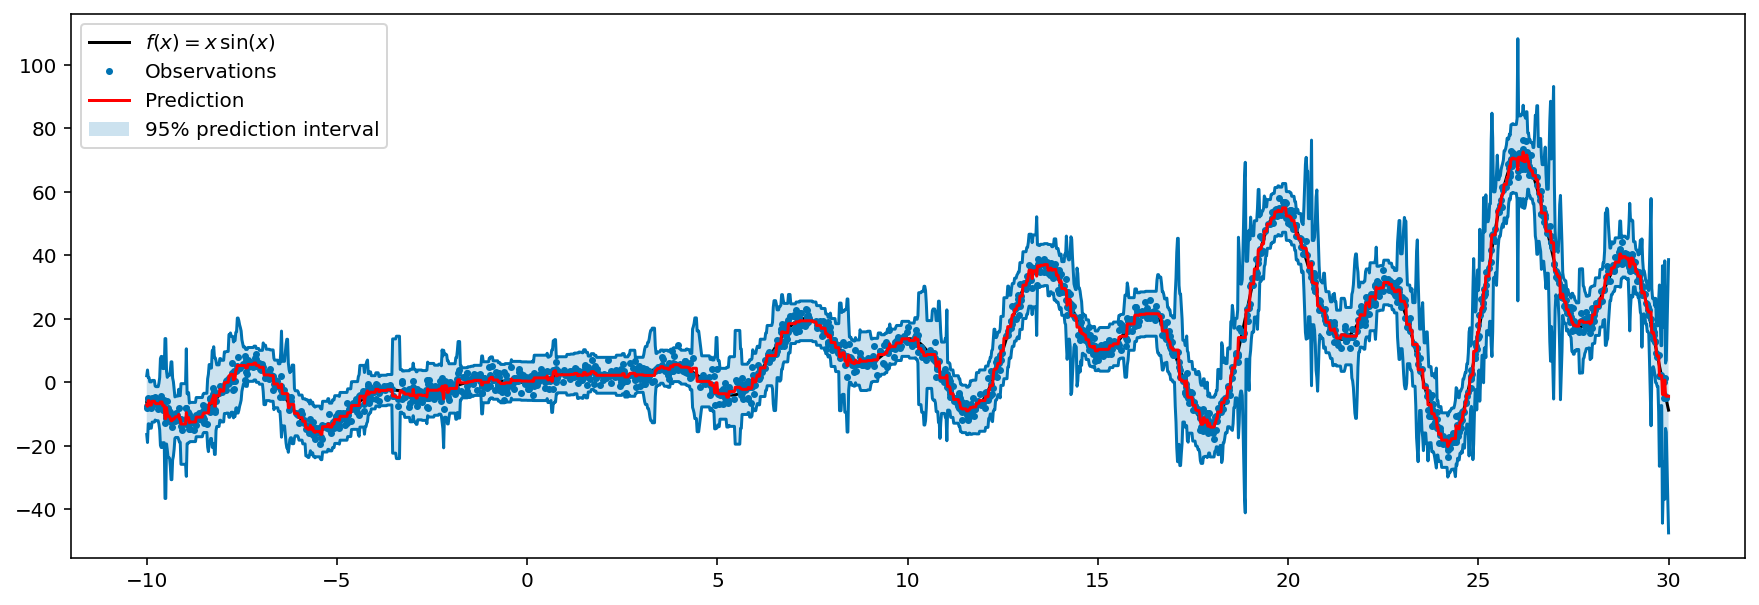

In [10]:
ax = plot_result(alpha=ALPHA, preds=de_preds, **data_kwargs)